## Data

In [171]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import warnings
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from collections import Counter

Получение данных

In [69]:
train_data = pd.read_csv("/content/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/content/kaggle/input/titanic/test.csv")
gender_data = pd.read_csv("/content/kaggle/input/titanic/gender_submission.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
train_data['train_test'] = 1
test_data['train_test'] = 0
all_data = pd.concat([train_data, test_data])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  num_cabins   891 non-null    float64
 13  train_test   1309 non-null   int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 153.4+ KB


## Feature engineering

In [ ]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print(f"{round(rate_women,4)}% of women survived")

0.742% of women survived


In [ ]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print(f"{round(rate_men, 4)}% of men survived")

0.1889% of men survived


Выжившие люди по возрасту и полу

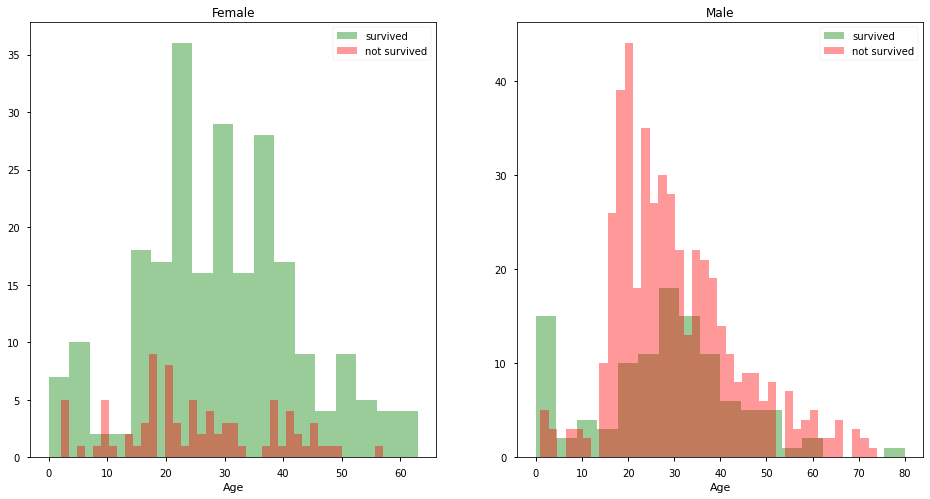

In [ ]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

In [53]:
px.scatter(train_data, x='PassengerId', y='Age', color='Survived', log_x=True, size='Fare')

Добавление признака num_cabins

In [70]:
num_cabins = train_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train_data['num_cabins'] = num_cabins

px.histogram(train_data, x='num_cabins', color='Survived', color_discrete_sequence=['crimson','darkseagreen'], barmode='group')

Добавление признака буква в названии кабины

In [63]:
cabin_letter = train_data.Cabin.apply(lambda x: str(x)[0])
train_data['cabin_letter'] = cabin_letter

px.histogram(train_data, x='cabin_letter', color='Survived', color_discrete_sequence=['crimson','darkseagreen'], barmode='group')

Получение признака Размер_семьи и Одиночество

In [151]:
all_data['FamilySize'] = all_data.Parch + all_data.SibSp + 1
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = 1

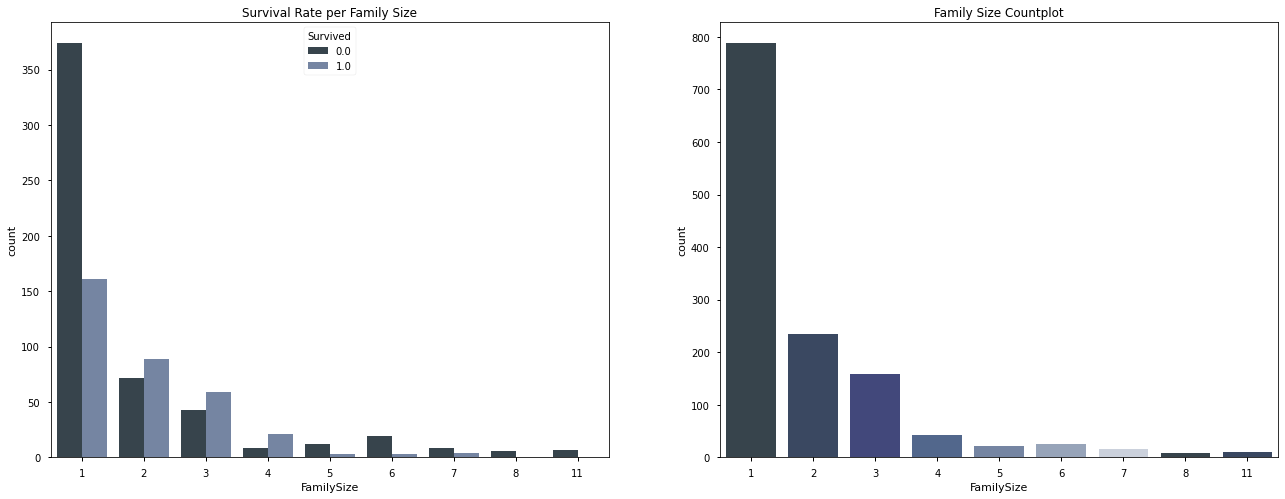

In [153]:
fig, axes = plt.subplots(figsize=(22,8), nrows = 1, ncols = 2)
ax = sns.countplot(x = 'FamilySize', hue='Survived', data = all_data, palette = ['#334550','#6D83AA'], ax = axes[0])
ax.set_title('Survival Rate per Family Size')
ax = sns.countplot(x = 'FamilySize', data = all_data, palette = ['#334550','#334668','#394184','#496595','#6D83AA','#91A2BF','#C8D0DF'], ax = axes[1])
_ = ax.set_title('Family Size Countplot')

In [154]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
all_data['FamilySizeGrouped'] = all_data['FamilySize'].map(family_map)

Обработка имени, получение "титула"

In [136]:
name_title_list = all_data["Name"].str.extract("([a-zA-Z]+)\.")[0]
counter_name_title = dict(Counter(name_title_list))
for name_title, count in counter_name_title.items():
  if count < 10:
    name_title_list = name_title_list.replace(name_title, 'Rare')

## Data prerocessing

Преобразование принаков: нормализация числовых, бинаризация значимых

In [150]:
all_data['num_cabins'] = train_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_letter'] = train_data.Cabin.apply(lambda x: str(x)[0])

all_data.dropna(subset=['Embarked'], inplace=True)

all_data.Age.fillna(all_data.Age.median(), inplace=True)
mediana = all_data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
all_data.Fare = all_data.Fare.fillna(mediana)

all_data["Title"] = name_title_list

all_data['norm_fare'] = np.log(all_data.Fare+1)

all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title', 'norm_fare', 'FamilySize', 'IsAlone', 'Embarked', 'cabin_letter', 'num_cabins', 'train_test']])
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1)

y_train = all_data[all_data.train_test == 1].Survived

In [161]:
scaler = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'norm_fare', 'SibSp', 'Parch']] = scaler.fit_transform(all_dummies_scaled[['Age', 'norm_fare', 'SibSp', 'Parch']])

x_train = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
x_test = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived.astype(int)

## Learning

Первоначальный код для первоначального результата обучения. Он равен 0.77751

In [149]:
"""
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

submission = pd.read_csv('/content/kaggle/input/titanic/gender_submission.csv')
submission['Survived'] = predictions
submission.to_csv('submission.csv', index=False)"""

Проверка результатов работы разных моделей без параметров с помощью cross_validation проверки

In [162]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors"]})
cv_res = cv_res.sort_values(by='CrossValMeans',ascending = False)


In [168]:
fig = make_subplots(rows=1, cols=1, 
                    specs=[[{"type": "bar"}]])

fig.add_trace(go.Bar(x=cv_res['CrossValMeans'], y=cv_res.Algorithm, marker=dict(color=['#334550','#334550','#334668','#334668','#496595','#496595','#6D83AA','#6D83AA','#91A2BF','#C8D0DF']),
                     name='Fare', orientation='h'), 
                     row=1, col=1)

fig.update_yaxes(showgrid=True, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=True, row=1, col=1)

fig.show()

Обучение на всех параметрах с помощью GridSearch и выбор лучшей с помощью VotingClassifier

In [174]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsadaDTC.fit(x_train,y_train)
ada_best = gsadaDTC.best_estimator_

# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsGBC.fit(x_train,y_train)
GBC_best = gsGBC.best_estimator_

# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsSVMC.fit(x_train,y_train)
SVMC_best = gsSVMC.best_estimator_

#ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(x_train,y_train)
ExtC_best = gsExtC.best_estimator_

# RandomForest
rfs = RandomForestClassifier()
rfs_param_grid = {"criterion": ['gini', 'entropy'],
              "n_estimators": [10, 25, 50, 100, 200, 500],
              "min_samples_split": [1, 2, 3, 5]}
gsRFS = GridSearchCV(rfs,param_grid = rfs_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsRFS.fit(x_train,y_train)
rfsGS_best = gsRFS.best_estimator_

# KNN
knn = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": [2, 3, 5, 10, 15, 25, 50],
              "leaf_size": [10, 15, 25, 40, 50],
              "p": [1, 2, 3],
              "metric": ['minkowski', 'euclidean', 'manhattan']}
gsKNN = GridSearchCV(knn,param_grid = knn_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsKNN.fit(x_train,y_train)
KNNGS_best = gsKNN.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
Fitting 10 folds for each of 72 candidates, totalling 720 fits
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Fitting 10 folds for each of 315 candidates, totalling 3150 fits


In [175]:
votingC = VotingClassifier(estimators=[('knn', KNNGS_best), ('rfc', rfsGS_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC.fit(x_train, y_train)
predictions_survived = votingC.predict(x_test)

## Results

In [176]:
predictions = pd.DataFrame({'Survived' : predictions_survived},index = all_data[all_data.Survived.isnull() == True].PassengerId)
predictions['Survived'] = predictions.Survived.astype(int)
predictions.to_csv('submission.csv')

В итоге после всех преобразований и обучния на всем объеме данных, получилось добиться 0.78468 в таблице рейтинга Kaggle